<a href="https://colab.research.google.com/github/chillMLguy/SysDec-projekt/blob/main/SDproj_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Projekt zaliczeniowy nr 1**

**Maksymilian Kulicki**

**448311**

Tematem projektu zaliczeniowego jest predykcja gier Hearthstone.

Projekt składa się się z części pierwszej, w której przeprowadzam podstawową eksploracyjną analizę danych oraz części drugiej, w której trenuję kilka modeli predykcyjnych oraz mierzę ich skuteczność.

###Biblioteki i import danych:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression


from google.colab import drive
drive.mount('/content/drive')


file_path = '/content/drive/My Drive/Colab Notebooks/SDprojekt/training_data_table.csv'
data = pd.read_csv(file_path)

Mounted at /content/drive


#Część I - Co możemy powiedzieć o Dataset'cie?

###Wygląd danych

In [ ]:
data.head()

,gamestate_id,decision,turn,opponent.armor,opponent.attack,opponent.hero_card_id,opponent.hp,opponent.special_skill_used,opponent.weapon_durability,opponent.crystals_all,...,player.played.hp_current,player.played.hp_max,player.hand.nOfMinions,player.hand.nOfSpells,player.hand.nOfWeapons,player.hand.nOfCards,player.hand.nOfPlayable,player.hand.attack,player.hand.crystals_cost,player.hand.hp
0,1948158.0,0,14,0,0,494,11,1,0,10,...,0,0,2,1,0,3,3,7,13,10
1,3843850.0,1,15,0,0,798,4,1,0,10,...,12,12,0,1,0,1,0,0,5,0
2,3200699.0,0,14,0,4,981,30,0,2,10,...,6,7,3,0,1,4,4,13,15,16
3,4151898.0,0,10,0,0,798,15,0,0,9,...,18,22,3,1,0,4,0,9,20,17
4,2432423.0,1,9,0,0,326,17,0,0,8,...,12,17,3,0,0,3,0,10,11,9


In [ ]:
print("Rozmiar danych :", data.shape)

Rozmiar danych : (3250000, 45)


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3250000 entries, 0 to 3249999
Data columns (total 45 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   gamestate_id                   float64
 1   decision                       int64  
 2   turn                           int64  
 3   opponent.armor                 int64  
 4   opponent.attack                int64  
 5   opponent.hero_card_id          int64  
 6   opponent.hp                    int64  
 7   opponent.special_skill_used    int64  
 8   opponent.weapon_durability     int64  
 9   opponent.crystals_all          int64  
 10  opponent.crystals_current      int64  
 11  opponent.deck_count            int64  
 12  opponent.fatigue_damage        int64  
 13  opponent.hand_count            int64  
 14  opponent.played_minions_count  int64  
 15  player.armor                   int64  
 16  player.attack                  int64  
 17  player.hero_card_id            int64  
 18  pl

###Liczba elementów poszczególnych klas decyzyjnych





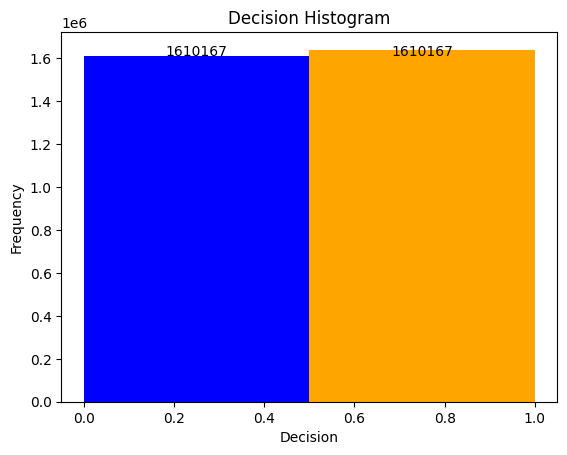

In [ ]:
n, bins, patches = plt.hist(data["decision"], bins = 2)
colors = ["blue", "orange"]


for patch, color, bin_left, bin_right in zip(patches, colors, bins[:-1], bins[1:]):
    patch.set_facecolor(color)
    x = (bin_left + bin_right) / 2
    plt.text(x, n[int(x)] + 0.2, str(int(n[int(x)])), ha='center', fontsize=10)

plt.xlabel("Decision")
plt.ylabel("Frequency")
plt.title("Decision Histogram")
plt.show()

Wniosek : klasy decyzyjne rozłożone mniej więcej po równo

### Czy brakuje danych ?

In [ ]:
print(data.isnull().sum())
print("Liczba brakujących danych: ", data.isnull().sum().sum())

gamestate_id                     0
decision                         0
turn                             0
opponent.armor                   0
opponent.attack                  0
opponent.hero_card_id            0
opponent.hp                      0
opponent.special_skill_used      0
opponent.weapon_durability       0
opponent.crystals_all            0
opponent.crystals_current        0
opponent.deck_count              0
opponent.fatigue_damage          0
opponent.hand_count              0
opponent.played_minions_count    0
player.armor                     0
player.attack                    0
player.hero_card_id              0
player.hp                        0
player.special_skill_used        0
player.weapon_durability         0
player.crystals_all              0
player.crystals_current          0
player.deck_count                0
player.fatigue_damage            0
player.hand_count                0
player.played_minions_count      0
opponent.played.nOfCards         0
opponent.played.atta

### Rozłożenie danych na obserwacje X i target y

In [ ]:
X = data.drop(["gamestate_id", "decision"], axis =1)
y = data["decision"]

### PCA

Sprawdźmy czy możemy zobaczyć zależności w danych


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


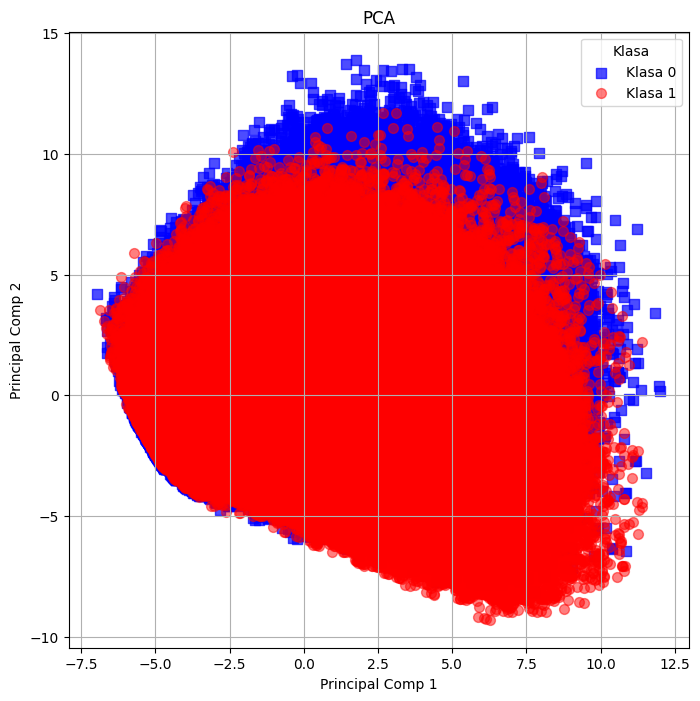

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


pca = PCA(n_components=2)
X_new = pca.fit_transform(X_scaled)


plt.figure(figsize=(8, 8))
class0 = X_new[y == 0]
class1 = X_new[y == 1]

plt.scatter(class0[:, 0], class0[:, 1], marker='s', color='blue', label='Klasa 0', s=50, alpha=0.7)
plt.scatter(class1[:, 0], class1[:, 1], marker='o', color='red', label='Klasa 1', s=50, alpha=0.5)

plt.xlabel("Principal Comp 1")
plt.ylabel("Principal Comp 2")
plt.title("PCA")
plt.legend(title="Klasa")
plt.grid(True)
plt.show()


In [ ]:
pca.explained_variance_ratio_.cumsum()

array([0.25114641, 0.39919106])

Niestety nie możemy nic powiedzieć o danych patrząc na ich PCA. Ponadto dla n=2 zmienność danych jest wytłumaczona przez ten model w około 40% co jest bardzo kiepskim wynikiem.

### Korelacja między cechami

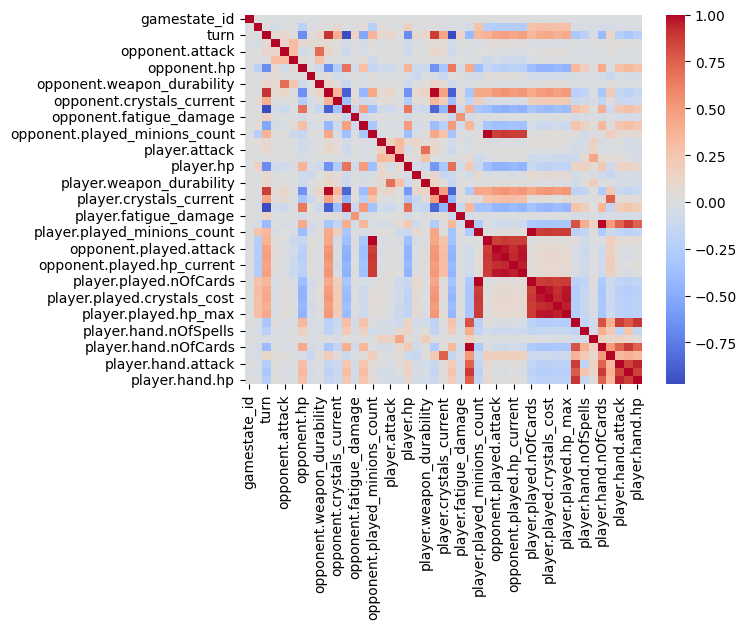

In [ ]:
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm')

plt.show()


Na macierzy korelacji widzimy możemy zobaczyć jakie cechy są ze sobą skorelowane, a jakie w ogóle. Np. możemy powiedzieć, że bardzo skorelowane są ze sobą cechy : opponent.played.attack, opponent.hp_current, player.played.nOfCards

### Rozkłady poszczególnych cech

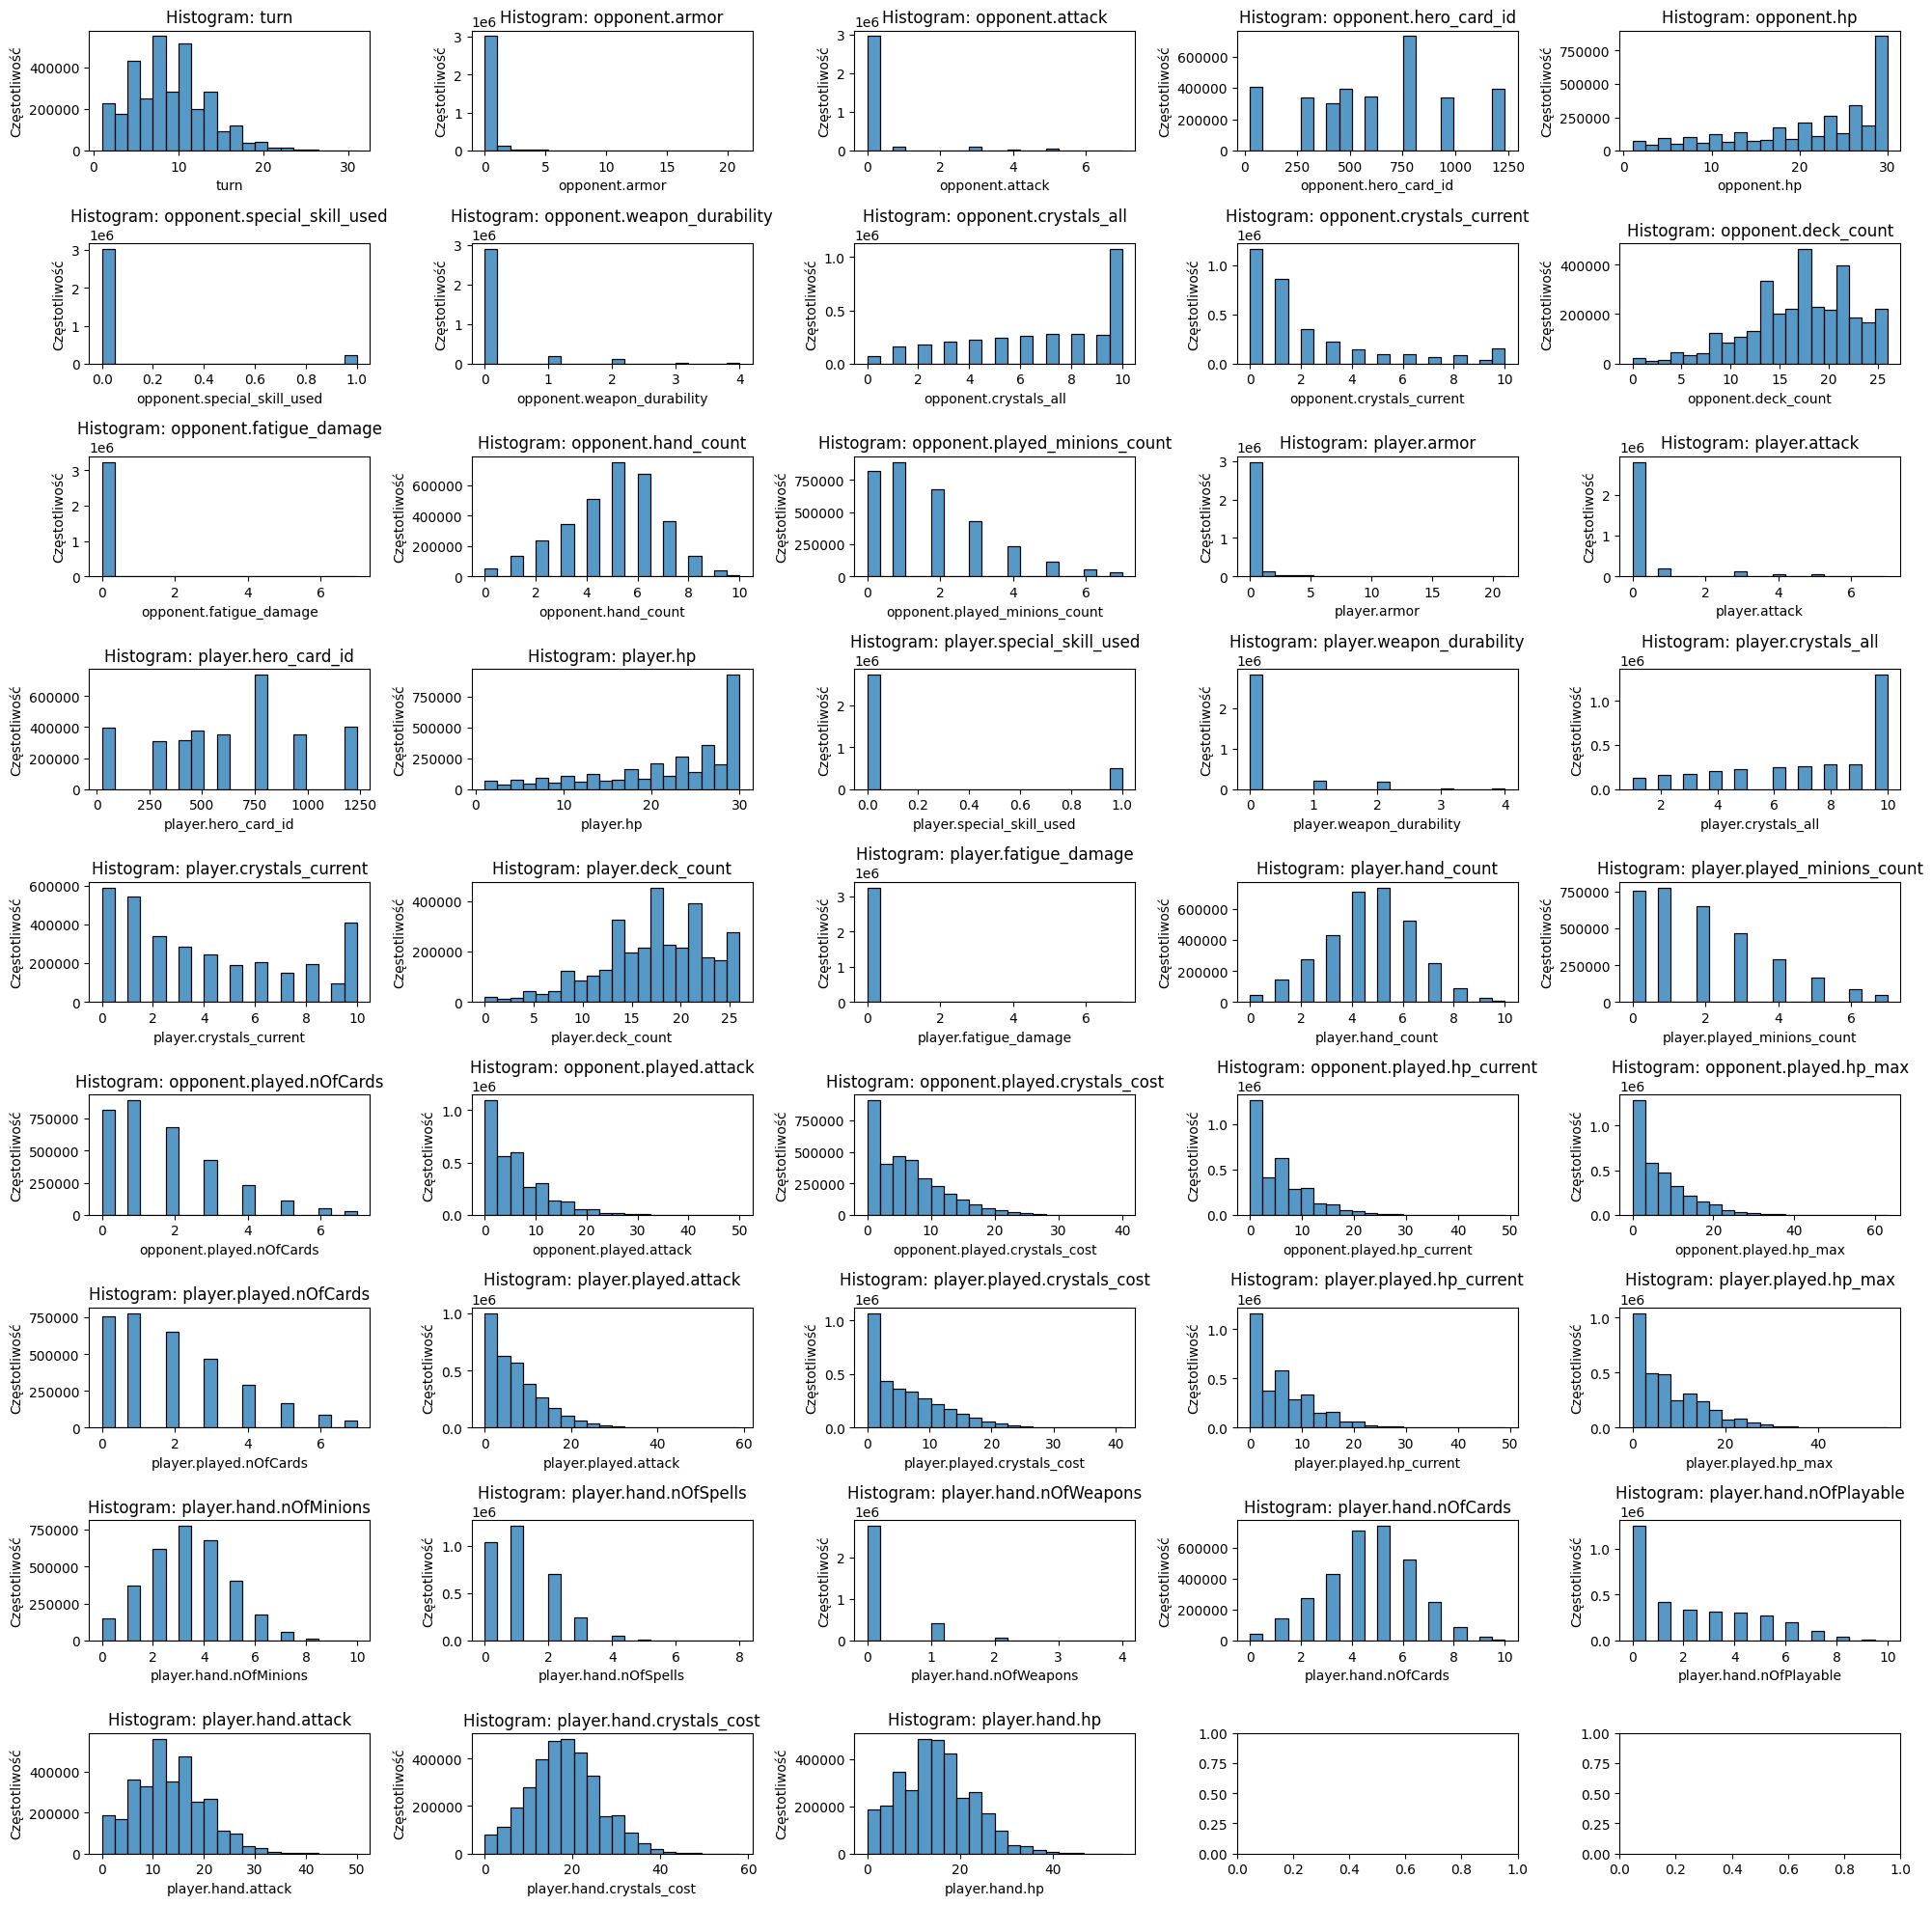

In [ ]:
n_cols = 5
n_rows = (len(X.columns) // n_cols) + (len(X.columns) % n_cols > 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20))

axes = axes.flatten()


for i, column in enumerate(X.columns):
    sns.histplot(X[column], bins=20, ax=axes[i])
    axes[i].set_title(f'Histogram: {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Częstotliwość')

plt.tight_layout()
plt.show()

### Podsumowanie częsci I

W częsci I przedstawiłem krótką ekploracyjną analizę danych. Krótką, ponieważ ważniejsza w tym projekcie są same modele predykcyjne.

Został przedstawiony wygląd danych, informacja o typie poszczególnych cech, informacja o brakujących danych, liczba elementów klas decyzyjnych, PCA, Macierz korelacji oraz rozkłady poszczególnych cech.

# Część II - Predykcja

Podział na dane testowe i treningowe

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

Modele

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


roc_data = {}
accuracy_data = {}

# Model 1: Regresja Logistyczna
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
log_pred = log_model.predict(X_test)
log_acc = accuracy_score(y_test, log_pred)
accuracy_data['Logistic Regression'] = log_acc
log_probs = log_model.predict_proba(X_test)[:, 1]
fpr_log, tpr_log, _ = roc_curve(y_test, log_probs)
roc_auc_log = auc(fpr_log, tpr_log)
roc_data['Logistic Regression'] = (fpr_log, tpr_log, roc_auc_log)



# Model 2: XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_acc = accuracy_score(y_test, xgb_pred)
accuracy_data['XGBoost'] = xgb_acc
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_probs)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
roc_data['XGBoost'] = (fpr_xgb, tpr_xgb, roc_auc_xgb)


# Model 3 : Sieć neuronowa
nn_model = Sequential([
    Dense(32, input_dim=X_train_scaled.shape[1], activation='relu'),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = nn_model.fit(X_train_scaled, y_train, epochs=10, batch_size=128, validation_data=(X_test_scaled, y_test), verbose=0)
nn_probs = nn_model.predict(X_test_scaled).ravel()
nn_pred = (nn_probs > 0.5).astype(int)
nn_acc = accuracy_score(y_test, nn_pred)
accuracy_data['Neural Network'] = nn_acc
fpr_nn, tpr_nn, _ = roc_curve(y_test, nn_probs)
roc_auc_nn = auc(fpr_nn, tpr_nn)
roc_data['Neural Network'] = (fpr_nn, tpr_nn, roc_auc_nn)




### Podsumowanie wyników

Poniżej znajduję się tabela z poszczególnymi modelami oraz wykres przedstawiający ROC

In [ ]:
summary = pd.DataFrame({
    'Model': list(accuracy_data.keys()),
    'Accuracy': list(accuracy_data.values()),
    'AUC': [roc_data[m][2] for m in accuracy_data.keys()]
})

summary

,Model,Accuracy,AUC
0,Logistic Regression,0.701634,0.787980
1,XGBoost,0.718948,0.809819
2,Neural Network,0.713320,0.803064


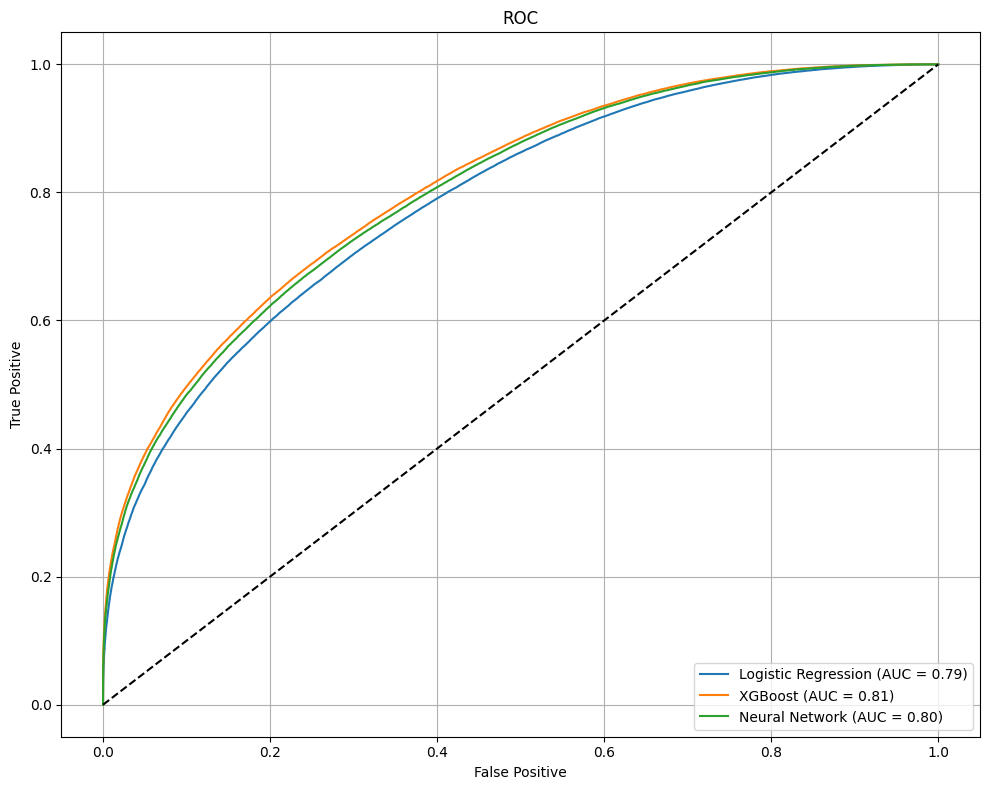

In [ ]:
plt.figure(figsize=(10, 8))
for model_name, (fpr, tpr, auc_score) in roc_data.items():
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive")
plt.ylabel("True Positive")
plt.title("ROC")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()

Najlepiej z trzech modeli poradził sobie XGBoost, więc ten model użyje do finalnej odpowiedzi.

### Użycie modelu XGBoost do zbioru testowego

In [ ]:
file_path2 = '/content/drive/My Drive/Colab Notebooks/SDprojekt/test_data_table_no_labels.csv'
data_test = pd.read_csv(file_path2)

In [ ]:
data_test.head()

,gamestate_id,decision,turn,opponent.armor,opponent.attack,opponent.hero_card_id,opponent.hp,opponent.special_skill_used,opponent.weapon_durability,opponent.crystals_all,...,player.played.hp_current,player.played.hp_max,player.hand.nOfMinions,player.hand.nOfSpells,player.hand.nOfWeapons,player.hand.nOfCards,player.hand.nOfPlayable,player.hand.attack,player.hand.crystals_cost,player.hand.hp
0,6908101.0,NaN,11,0,0,326,15,0,0,10,...,5,5,2,0,0,2,2,4,7,7
1,6332692.0,NaN,7,0,0,25,30,0,0,6,...,10,10,4,1,0,5,0,15,24,24
2,9388928.0,NaN,8,0,0,798,30,1,0,7,...,0,0,4,2,0,6,4,15,22,18
3,5652984.0,NaN,7,0,0,326,30,1,0,6,...,13,13,4,1,0,5,5,16,21,24
4,5108335.0,NaN,9,0,0,981,23,0,0,8,...,14,16,2,1,1,4,2,11,15,12


In [ ]:
X_test_new = data_test.drop(["gamestate_id", "decision"], axis =1)
probabilities = xgb_model.predict_proba(X_test_new)[:, 1]

In [ ]:
np.savetxt('predykcje.txt', probabilities, fmt='%f')

### Podsumowanie części II

W części drugiej budowaliśmy modele predykcyjne. Modele użyte w zadaniu to : Regresja Logistyczna, XGBoost oraz Sieć neuronowa.

Obliczając liczbę AUC dla każdego modelu decydujemy, że finalnym modelem użytym do odpowiedzi będzie XGBoost.